<h1>Imports</h1>

In [2]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 100)
%matplotlib inline

<h1>Dataset Importing</h1>

In [4]:
DATA_PATH = Path.cwd() / "../../datasets"

In [4]:
training_df = pd.read_csv(DATA_PATH / "train.csv", index_col="tripid")
training_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


<h1>Data Preprocessing</h1>

In [5]:
training_df['pickup_time'] = pd.to_datetime(training_df['pickup_time'], format="%m/%d/%Y %H:%M")
training_df['drop_time'] = pd.to_datetime(training_df['drop_time'], format="%m/%d/%Y %H:%M")

In [6]:
training_df['label_marker']=(training_df['label']=='correct').astype(int)

<h1>Initial Data Analyisis</h1>

<h3>Weka analysis of outliers</h3>

In [7]:
weka_outliers = pd.read_csv(DATA_PATH / "train_outlier.csv", index_col="tripid")

In [15]:
print(weka_outliers[weka_outliers['Outlier'] == 'yes'].index.tolist())

[189146174, 189157607, 189160756, 189176766, 189182800, 189191865, 189227008, 189236485, 189252401, 189259043, 189277797, 189284005, 189307311, 189323004, 189345964, 189363308, 189370252, 189372731, 189391717, 189394373, 189420181, 189428397, 189431382, 189433901, 189445521, 189449518, 189465650, 189475280, 189551186, 189572039, 189615129, 189623692, 189626199, 189627696, 189640410, 189655834, 189667686, 189670152, 189698072, 189738377, 189737409, 189734544, 189748039, 189747601, 189752791, 189778822, 189801272, 189820422, 189820090, 189820141, 189821179, 189824507, 189826263, 189829043, 189826754, 189835514, 189841958, 189842329, 189876756, 189877959, 189882220, 189884798, 189894385, 189893586, 189925207, 189980243, 189978643, 189995541, 190007029, 190008226, 190009896, 190010618, 190017339, 190023371, 190025934, 190042045, 190050433, 190050729, 190056653, 190059653, 190065135, 190066074, 190070075, 190080854, 190100669, 190108454, 190166142, 190173251, 190176497, 190184600, 190189374

In [7]:
training_df.dtypes

additional_fare                     float64
duration                            float64
meter_waiting                       float64
meter_waiting_fare                  float64
meter_waiting_till_pickup           float64
pickup_time                  datetime64[ns]
drop_time                    datetime64[ns]
pick_lat                            float64
pick_lon                            float64
drop_lat                            float64
drop_lon                            float64
fare                                float64
label                                object
label_marker                          int64
dtype: object

In [8]:
training_df.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'label_marker'],
      dtype='object')

<h2>Initial Feature Correlation</h2>

In [9]:
heatmap_initial = training_df.corr()

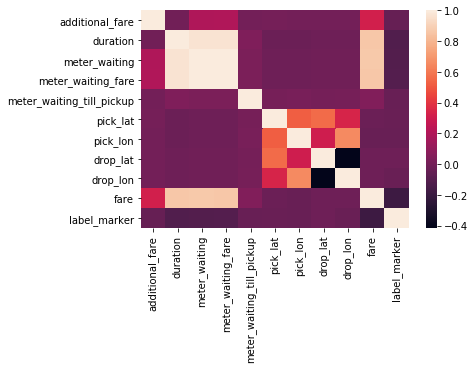

In [10]:
sns.heatmap(heatmap_initial)

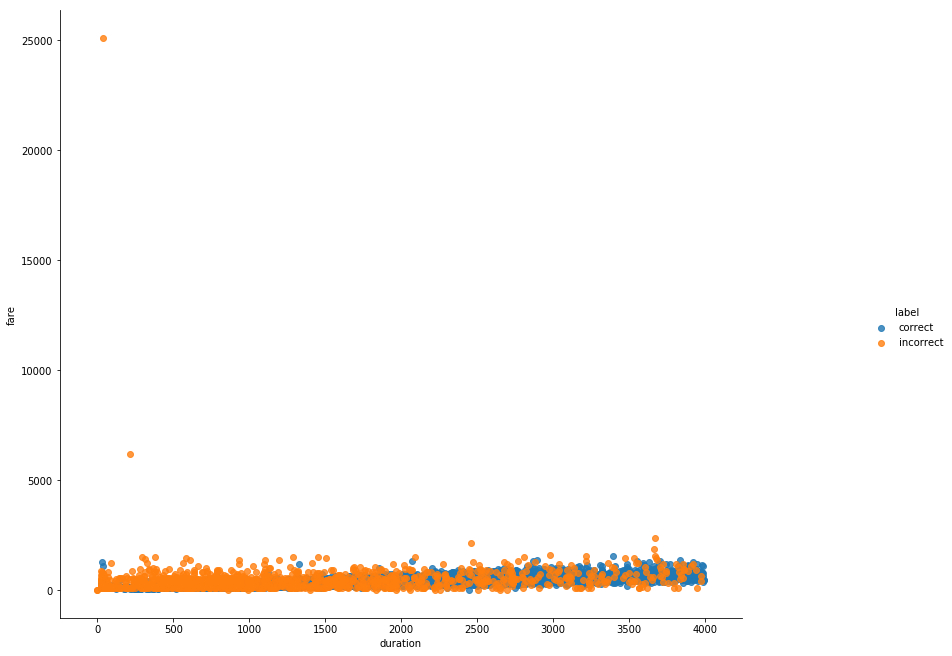

In [11]:
sns.lmplot('duration', 'fare', training_df[training_df['duration']<4000], hue='label', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

<h2>Identification of Anomalies within the Correct dataset</h2>
<b>Consider only correct as Anomalies within the correct data maybe called 'incorrect' due to the anomaly<b>

In [12]:
training_df.isna().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
label_marker                   0
dtype: int64

In [13]:
correct_training_df = training_df[training_df['label']=='correct']

<h3>Null and Zero variable Analysis</h3>

In [14]:
correct_training_df.isna().sum()

additional_fare              53
duration                     53
meter_waiting                53
meter_waiting_fare           53
meter_waiting_till_pickup    53
pickup_time                   0
drop_time                     0
pick_lat                      0
pick_lon                      0
drop_lat                      0
drop_lon                      0
fare                          0
label                         0
label_marker                  0
dtype: int64

<b>All Rows with unspecified fare are incorrect<b>

In [15]:
corrNaNRows = correct_training_df[correct_training_df.isnull().any(axis=1)]

In [16]:
corrNaNRows.shape

(53, 14)

<b>All NaN entries are on the same row and are not dispersed<b>

In [17]:
zero_count = {}
negative_count = {}
for i in ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare'] :
    zero_count[i] = 0
    negative_count[i] = 0
    for index,row in correct_training_df.iterrows():
        if row[i] < 0:
            negative_count[i]+=1
        if row[i] == 0:
            zero_count[i]+=1

In [18]:
print(zero_count)
print(negative_count)

{'additional_fare': 1, 'duration': 0, 'meter_waiting': 636, 'meter_waiting_fare': 7568, 'meter_waiting_till_pickup': 1319, 'fare': 1}
{'additional_fare': 0, 'duration': 0, 'meter_waiting': 0, 'meter_waiting_fare': 0, 'meter_waiting_till_pickup': 0, 'fare': 0}


<b>No negative counts<b>

In [19]:
correct_training_df[correct_training_df['fare']==0]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,label_marker
tripid,,,,,,,,,,,,,,
191841099,0.0,2446.0,840.0,0.0,231.0,2019-11-14 08:25:00,2019-11-14 09:06:00,6.85527,79.8882,6.87782,79.8773,0.0,correct,1


<b>All rows with fare = 0 [except 191841099] are marked incorrect <b> <br/>
<b>All rows with fare = 0 also have 0 additional fare and meter waiting fare<b> <br/>
<b>Row could be an anomaly<b>

<h1>Initial Data Cleaning</h1>

<h1>Feature Engineering</h1>

In [20]:
# Bin times into 3 ranges to simplify time ascpect
training_df = training_df.assign(timeOfDay=pd.cut(training_df.pickup_time.dt.hour,[-1, 8, 20, 24],labels=['dawn','day', 'night']))

training_df['isDawn']=(training_df['timeOfDay']=='dawn').astype(int)
training_df['isNight']=(training_df['timeOfDay']=='night').astype(int)
training_df['isDay']=(training_df['timeOfDay']=='day').astype(int)

In [21]:
durations = []
for index,row in training_df.iterrows():
    provided_duration = row['duration'] 
    if math.isnan(provided_duration) or provided_duration <= 0 :
        time_dif = (row['drop_time'] - row['pickup_time']).seconds
        if time_dif == 0:
            time_dif = np.nan
        durations.append(time_dif)
    else :  
        durations.append(provided_duration)

training_df.insert(10,"time_dif",durations)

In [22]:
def dist_from_coordinates(lat1, lon1, lat2, lon2):
    R = 6371  
    d_lat = np.radians(lat2-lat1)
    d_lon = np.radians(lon2-lon1)

    r_lat1 = np.radians(lat1)
    r_lat2 = np.radians(lat2)
    a = np.sin(d_lat/2.) **2 + np.cos(r_lat1) * np.cos(r_lat2) * np.sin(d_lon/2.)**2

    haversine = 2 * R * np.arcsin(np.sqrt(a))

    return haversine

In [23]:
distances = []                    #empty column for distance
for index,row in training_df.iterrows():
    lat1 = row['pick_lat'] 
    lon1 = row['pick_lon'] 
    lat2 = row['drop_lat'] 
    lon2 = row['drop_lon'] 
    value = dist_from_coordinates(lat1, lon1, lat2, lon2)  
    distances.append(value)   

training_df.insert(10,"distance",distances)

In [24]:
training_df['time_driven'] = training_df['duration']  - training_df['meter_waiting']

In [25]:
training_df['driving_fare'] = training_df['fare']  - training_df['meter_waiting_fare'] - training_df['additional_fare']

In [26]:
costsperkm = []
for index,row in training_df.iterrows():
    if row['distance'] == 0:
        costperkm = np.nan
            
    else:
        costperkm = (row['driving_fare'] / row['distance'])
    costsperkm.append(costperkm)

training_df.insert(4,"cost_per_km",costsperkm)

In [27]:
avgspeeds = []
for index,row in training_df.iterrows():
    if(row['time_driven'] == 0):
        avgspeed = np.nan
    else:
        avgspeed = (row['distance'] / row['time_driven'] * 3600)
    avgspeeds.append(avgspeed)

training_df.insert(4,"avg_speed",avgspeeds)



In [28]:
chargeperhours = []
for index,row in training_df.iterrows():
    if(row['meter_waiting'] == 0):
        chargeperhour = np.nan
    else:
        chargeperhour = (row['meter_waiting_fare'] / row['meter_waiting'] * 3600)
    chargeperhours.append(chargeperhour)

training_df.insert(4,'charge_per_hour',chargeperhours)


In [29]:
training_df.loc[training_df['timeOfDay'] == 'day', 'isNormalCharge'] = 1
training_df.loc[training_df['timeOfDay'] != 'day', 'isNormalCharge'] = 0

<h1>Post feature engineering Analysis</h1>

In [30]:
training_df.columns[training_df.dtypes == "float64"].values

array(['additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'charge_per_hour', 'avg_speed',
       'cost_per_km', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon',
       'drop_lat', 'distance', 'time_dif', 'drop_lon', 'fare',
       'time_driven', 'driving_fare', 'isNormalCharge'], dtype=object)

In [ ]:
numerical_features = [ 'duration', 'meter_waiting',
       'meter_waiting_fare', 'charge_per_hour', 'avg_speed',
       'cost_per_km', 'meter_waiting_till_pickup', 'distance', 'time_dif', 'fare',
       'time_driven', 'driving_fare']
numerical_features_with_label = ['duration', 'meter_waiting',
       'meter_waiting_fare', 'charge_per_hour', 'avg_speed',
       'cost_per_km', 'meter_waiting_till_pickup', 'distance', 'time_dif', 'fare',
       'time_driven', 'driving_fare','label']

In [35]:
numerical_features = ['additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon',
       'drop_lat' ,'drop_lon', 'fare']
numerical_features_with_label = [ 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon',
       'drop_lat' ,'drop_lon', 'fare','label']

In [53]:
training_features = training_df[numerical_features]

In [54]:
training_features_with_labels = training_df[numerical_features_with_label]

<h2>Z score for numerical columns</h2>

In [56]:
training_features = training_features.dropna()

In [74]:
training_features.index

Int64Index([189123628, 189125358, 189125719, 189127273, 189129552, 189132829,
            189135103, 189139296, 189138671, 189135814,
            ...
            213795752, 213799350, 213800748, 213802197, 213802222, 213803193,
            213812756, 213813930, 213815405, 213817296],
           dtype='int64', name='tripid', length=16968)

In [72]:
inliers = training_features[(np.abs(stats.zscore(training_features)) < 3).all(axis=1)]

In [73]:
inliers.index

Int64Index([189123628, 189125358, 189125719, 189127273, 189129552, 189132829,
            189135103, 189139296, 189138671, 189135814,
            ...
            213795752, 213799350, 213800748, 213802197, 213802222, 213803193,
            213812756, 213813930, 213815405, 213817296],
           dtype='int64', name='tripid', length=16567)

In [77]:
diff_index = training_features.index.difference(inliers.index)

In [79]:
print(diff_index.tolist())

[189160756, 189213407, 189307311, 189345964, 189418240, 189431382, 189445521, 189475280, 189663502, 189667686, 189670152, 189765236, 189800308, 189820422, 189841958, 189842329, 189989861, 190017339, 190059653, 190100669, 190108454, 190167541, 190189374, 190240764, 190371740, 190390160, 190392777, 190439600, 190465231, 190579195, 190616564, 190630270, 190632321, 190679701, 190757034, 190768625, 190871768, 191004988, 191056435, 191062441, 191067600, 191098402, 191125782, 191175923, 191245326, 191253555, 191315141, 191328606, 191362317, 191364887, 191367425, 191371136, 191409182, 191425016, 191486731, 191494949, 191557599, 191569507, 191584433, 191949862, 191961350, 192118009, 192118666, 192121471, 192190626, 192227971, 192342254, 192424245, 192603743, 192666104, 192680516, 192749835, 192930989, 193029201, 193333812, 193341290, 193363687, 193453026, 193464877, 193484505, 193659984, 193677619, 193755306, 193781025, 193827380, 193841338, 193848497, 193874272, 193886201, 193898575, 193912639

<h2>IQR Anaylsis</h2>

<b>General Anaylsis of entire dataset</b>

In [ ]:
train_features = training_df[numerical_features]

In [ ]:
Q1 = train_features.quantile(0.25)
Q3 = train_features.quantile(0.75)
IQR = Q3-Q1
print(IQR)

In [ ]:
print ( (train_features < (Q1 - 3 * IQR)) | (train_features > (Q3 + 3 * IQR)) )

In [ ]:
training_df_out =  train_features[ ~((train_features < (Q1 - 3 * IQR)) | (train_features > (Q3 + 3 * IQR))).any(axis=1) ]

In [ ]:
training_df_out.shape

<b>Outlier from analyzing inccorrect cases</b>

In [ ]:
incorrect_training_df = training_features_with_labels[training_features_with_labels['label']=='incorrect']

In [ ]:
Q1_incorr = incorrect_training_df[numerical_features].quantile(0.25)
Q3_incorr = incorrect_training_df[numerical_features].quantile(0.75)
IQR_incorr = Q3_incorr-Q1_incorr
print(IQR_incorr)

In [ ]:
incorrect_train_features = incorrect_training_df[numerical_features]

In [ ]:
print ( (incorrect_train_features < (Q1_incorr - 3 * IQR_incorr)) | (incorrect_train_features > (Q3_incorr + 3 * IQR_incorr)) )

In [ ]:
incorrect_training_df_out =  incorrect_train_features[ ~((incorrect_train_features < (Q1_incorr - 3 * IQR_incorr)) | (incorrect_train_features > (Q3_incorr + 3 * IQR_incorr))).any(axis=1) ]

In [ ]:
incorrect_training_df_out.shape

<b>Outlier from analyzing correct cases</b>

In [ ]:
correct_training_df = training_features_with_labels[training_features_with_labels['label']=='correct']

In [ ]:
Q1_corr = correct_training_df[numerical_features].quantile(0.25)
Q3_corr = correct_training_df[numerical_features].quantile(0.75)
IQR_corr = Q3_corr-Q1_corr
print(IQR_corr)

In [ ]:
correct_train_features = correct_training_df[numerical_features]

In [ ]:
correct_train_features.shape

In [ ]:
print ( (correct_train_features < (Q1_corr - 3 * IQR_corr)) | (correct_train_features > (Q3_corr + 3 * IQR_corr)) )

In [ ]:
correct_training_df_out =  correct_train_features[ ~((correct_train_features < (Q1_corr - 3 * IQR_corr)) | (correct_train_features > (Q3_corr + 3 * IQR_corr))).any(axis=1) ]

In [ ]:
correct_training_df_out.shape

<h2>Graph anaylsis</h2>

In [ ]:
hue_order = ['incorrect','correct']
sns.lmplot('time_driven', 'driving_fare',training_df[(training_df['time_driven']>0) & (training_df['time_driven']<1000)],hue_order=hue_order, hue='label', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [ ]:
training_df.corr()

In [ ]:
zero_count = {}
negative_count = {}
for i in ['avg_speed','driving_fare','time_driven','distance'] :
    zero_count[i] = 0
    negative_count[i] = 0
    for index,row in training_df.iterrows():
        if row[i] < 0:
            negative_count[i]+=1
        if row[i] == 0:
            zero_count[i]+=1

In [ ]:
print(zero_count)
print(negative_count)

<h3>Viewing features of the Incorrect Dataset</h3>

In [ ]:
incorrect_training_df = training_df[training_df['label']=='incorrect']

In [ ]:
incorrect_training_df[incorrect_training_df['meter_waiting'] < 3600].plot(kind='scatter',x='meter_waiting',y='charge_per_hour',color='red')

<h2>Identification of Anomalies within the Correct dataset</h2>
<b>Consider only correct as Anomalies within the correct data maybe called 'incorrect' due to the anomaly<b>

In [ ]:
correct_training_df = training_df[training_df['label']=='correct']

In [ ]:
correct_training_df.nlargest(10, ['cost_per_km'])

In [ ]:
correct_training_df.plot(kind='scatter',y='cost_per_km',x='distance')

In [ ]:
zero_count = {}
negative_count = {}
for i in ['avg_speed','driving_fare','time_driven','distance', 'charge_per_hour'] :
    zero_count[i] = 0
    negative_count[i] = 0
    for index,row in correct_training_df.iterrows():
        if row[i] < 0:
            negative_count[i]+=1
        if row[i] == 0:
            zero_count[i]+=1

In [ ]:
print(zero_count)
print(negative_count)

In [ ]:
correct_training_df[correct_training_df['avg_speed'] < 0] 

<b>row 207947602 is anomolous as the driving time is negative<b>

In [ ]:
correct_training_df[correct_training_df['time_driven'] == 0] 

In [ ]:
correct_training_df[correct_training_df['time_driven'] < 60]

<h1>Post feature engineering Data cleaning</h1>